# Experimentación con GMM

In [2]:
import numpy as np
from sklearn.cluster import KMeans as SKMeans
import GMM
from importlib import reload
import seaborn as sns
import matplotlib.pyplot as plt
from kmeans_plus_plus import KMeans
from sklearn.model_selection import ParameterGrid
import pandas as pd

# Utils

In [37]:
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score, mutual_info_score, normalized_mutual_info_score

def calculate_clustering_metrics(X, cluster_labels, true_labels):
    
    silhouette = silhouette_score(X, cluster_labels)  # Silhouette Score
    rand_index = rand_score(true_labels, cluster_labels)  # Rand Index
    adjusted_rand = adjusted_rand_score(true_labels, cluster_labels)  # Adjusted Rand Index
    mutual_info = mutual_info_score(true_labels, cluster_labels)  # Mutual Information
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)  # Normalized Mutual Information
    
    metrics = {
        "silhouette": silhouette,
        "rand_index": rand_index,
        "rand_index_adjusted": adjusted_rand,
        "mutual_info": mutual_info,
        "mutual_info_normalized": nmi
    }

    return metrics
def load_features_ids_labels(filename:str, has_labels=True):
    """
    Description:
        Cargar los features, ids y labels de un archivo npz.
        Si es data de testeo, has_labels=False
    """
    contents = np.load(filename, allow_pickle=True)
    features = contents['features']
    ids = contents['ids']
    if has_labels:
        labels = contents['labels']
        return features, ids, labels
    return features, ids

# Load Data

In [38]:
train_tsne_2d = np.load('reduction/train/train_tsne_2d.npy')
test_tsne_2d = np.load('reduction/test/test_tsne_2d.npy')
val_tsne_2d = np.load('reduction/val/val_tsne_2d.npy')

train_tsne_3d = np.load('reduction/train/train_tsne_3d.npy')
test_tsne_3d = np.load('reduction/test/test_tsne_3d.npy')
val_tsne_3d = np.load('reduction/val/val_tsne_3d.npy')

train_umap_2d = np.load('reduction/train/train_umap_2d.npy')
test_umap_2d = np.load('reduction/test/test_umap_2d.npy')
val_umap_2d = np.load('reduction/val/val_umap_2d.npy')

train_umap_3d = np.load('reduction/train/train_umap_3d.npy')
test_umap_3d = np.load('reduction/test/test_umap_3d.npy')
val_umap_3d = np.load('reduction/val/val_umap_3d.npy')

y_train = np.load('reduction/train_numeric_labels.npy')

_,_, y_val = load_features_ids_labels('features_np/features_val.npz')
del _

In [23]:
_,_, y_train_labels = load_features_ids_labels('features_np/features_train.npz')
y_train_labels = y_train_labels.flatten()

In [5]:
unique_labels, y_val_encoded = np.unique(y_val, return_inverse=True)
y_val_encoded = y_val_encoded.flatten()
_, test_ids = load_features_ids_labels('features_np/features_test.npz', has_labels=False)

# Train KMeans

### Custom implementation (kmeans++)

In [6]:
# 2D t-SNE
kmeans_tsne_2d = KMeans(n_clusters=10, random_state=42)
kmeans_tsne_2d.fit_predict(train_tsne_2d)

# 3D t-SNE
kmeans_tsne_3d = KMeans(n_clusters=10, random_state=42)
kmeans_tsne_3d.fit_predict(train_tsne_3d)

# 2D UMAP
kmeans_umap_2d = KMeans(n_clusters=10, random_state=42)
kmeans_umap_2d.fit_predict(train_umap_2d)

# 3D UMAP
kmeans_umap_3d = KMeans(n_clusters=10, random_state=42)
kmeans_umap_3d.fit_predict(train_umap_3d)

array([5, 5, 9, ..., 2, 6, 9])

### Scikit-learn implementation

In [7]:
# 2D t-SNE
skmeans_tsne_2d = SKMeans(n_clusters=10, random_state=42)
skmeans_tsne_2d.fit_predict(train_tsne_2d)

# 3D t-SNE
skmeans_tsne_3d = SKMeans(n_clusters=10, random_state=42)
skmeans_tsne_3d.fit_predict(train_tsne_3d)

# 2D UMAP
skmeans_umap_2d = SKMeans(n_clusters=10, random_state=42)
skmeans_umap_2d.fit_predict(train_umap_2d)

# 3D UMAP
skmeans_umap_3d = SKMeans(n_clusters=10, random_state=42)
skmeans_umap_3d.fit_predict(train_umap_3d)


array([5, 5, 3, ..., 7, 9, 3], dtype=int32)

# Plots: cómo debería verse la data después de las predicciones

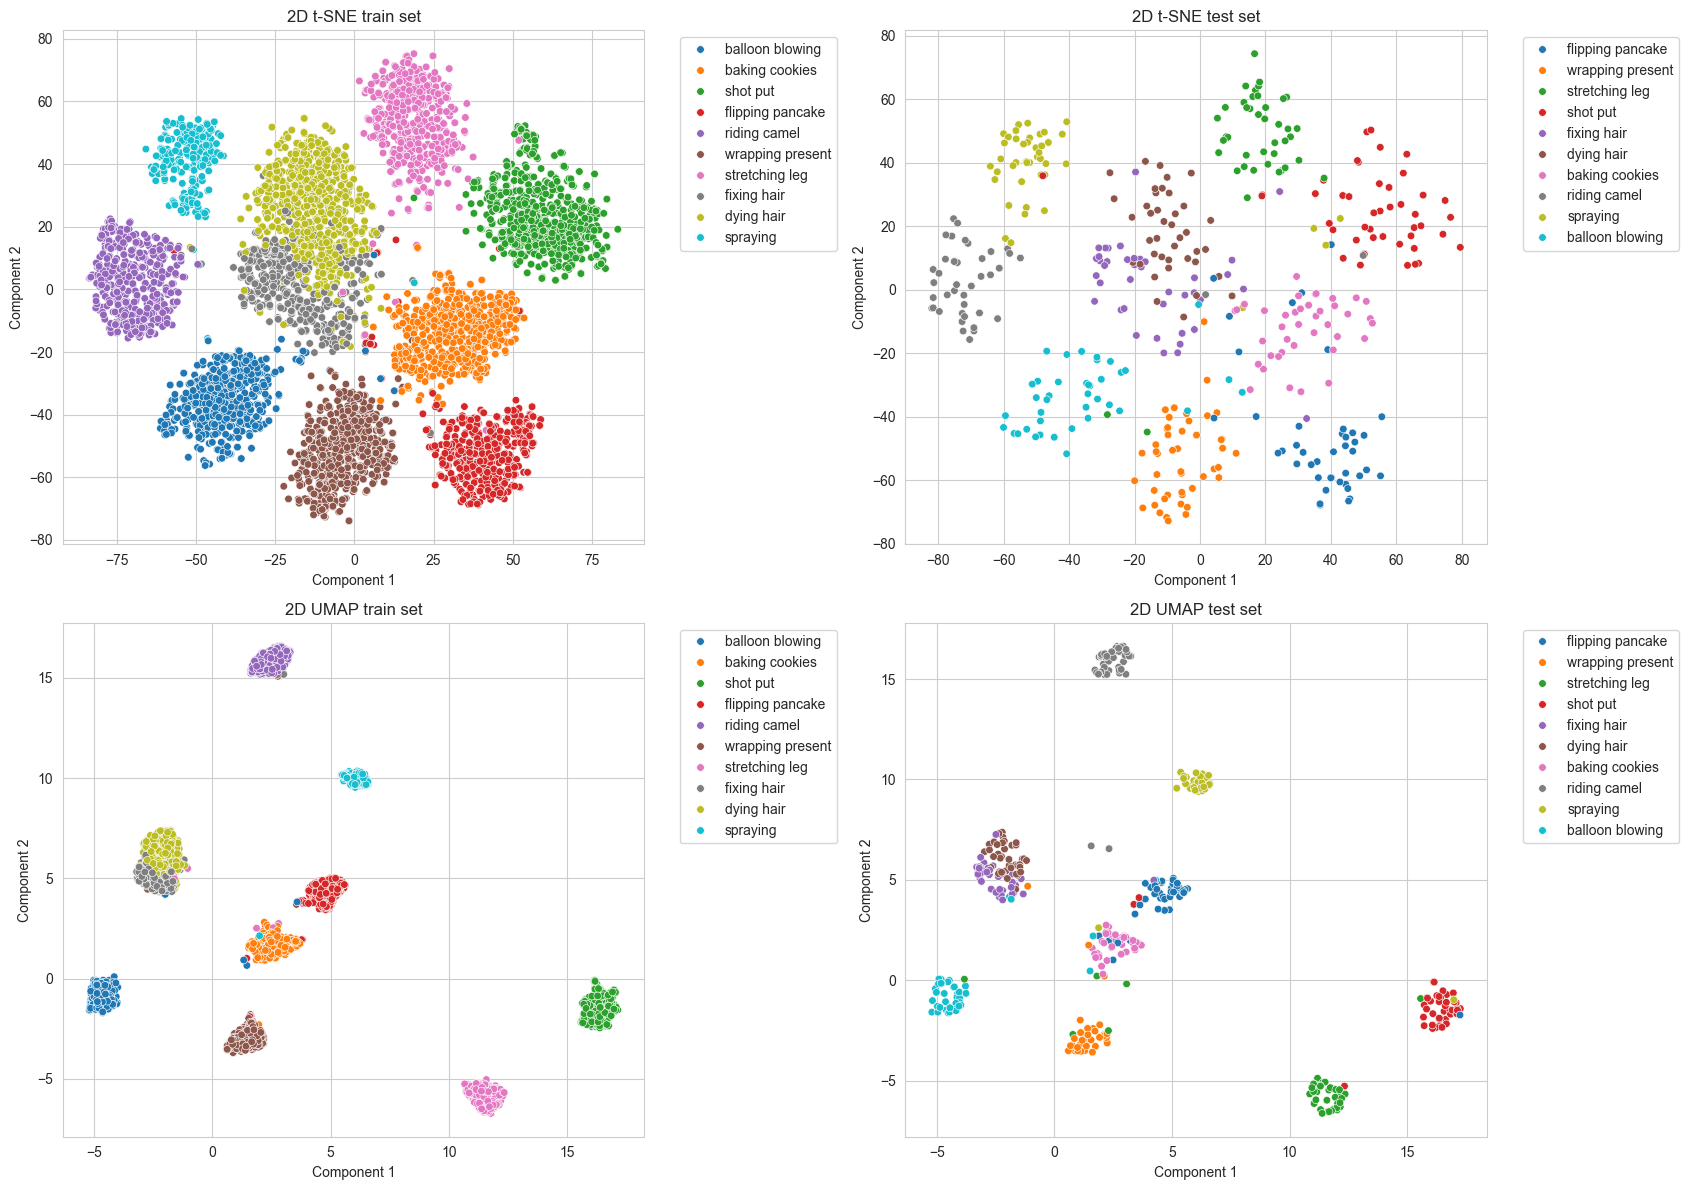

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(17, 12))
sns.set_style('whitegrid')
sns.scatterplot(x=train_tsne_2d[:, 0], y=train_tsne_2d[:, 1], hue=y_train_labels, palette='tab10', ax=axs[0][0], s=30)
sns.scatterplot(x=val_tsne_2d[:, 0], y=val_tsne_2d[:, 1], hue=y_val.flatten(), palette='tab10', ax=axs[0][1], s=30)

sns.scatterplot(x=train_umap_2d[:, 0], y=train_umap_2d[:, 1], hue=y_train_labels.flatten(), palette='tab10', ax=axs[1][0], s=30)
sns.scatterplot(x=val_umap_2d[:, 0], y=val_umap_2d[:, 1], hue=y_val.flatten(), palette='tab10', ax=axs[1][1], s=30)

axs[0][0].set_title('2D t-SNE train set')
axs[0][1].set_title('2D t-SNE test set')
axs[1][0].set_title('2D UMAP train set')
axs[1][1].set_title('2D UMAP test set')

for ax in axs.flat:
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# GMM

In [7]:
data = {
    'tsne': {
        2: [train_tsne_2d, test_tsne_2d, val_tsne_2d, kmeans_tsne_2d, skmeans_tsne_2d],
        3: [train_tsne_3d, test_tsne_3d, val_tsne_3d, kmeans_tsne_3d, skmeans_tsne_3d],
    },
    'umap': {
        2: [train_umap_2d, test_umap_2d, val_umap_2d, kmeans_umap_2d, skmeans_umap_2d],
        3: [train_umap_3d, test_umap_3d, val_umap_3d, kmeans_umap_3d, skmeans_umap_3d]
    }
}

In [10]:
def experimentation(dim_reduc='tsne', dims=2, knn_implementation='own', tol=1e-3, n_trials=3):
    records = []
    x_ = data[dim_reduc][dims]
    centroids = None
    if knn_implementation == 'own':
        centroids = x_[3].centroids
    else:
        centroids = x_[4].cluster_centers_
    i = 0
    while i < n_trials:
        try:
            gmm = GMM.GMM(n_clusters=10, print_freq=200, tol=tol)
            gmm.fit(x_[0], centroids=centroids)
            pred = gmm.predict(X=x_[2])
            metrics = calculate_clustering_metrics(X=x_[2], cluster_labels=pred, true_labels=y_val_encoded)
            metrics['dim_reduc'] = dim_reduc
            metrics['n_dims'] = dims
            metrics['knn_implementation'] = knn_implementation
            metrics['n_trial'] = i
            metrics['tol'] = tol
            metrics['log_likelihood'] = gmm.log_ll
            records.append(metrics)
            i+=1
        except Exception as e:
            print("There was an exception. Trying again. ", str(e))
    return records

In [9]:
results = []

In [ ]:
parameters = {
    'knn_implementation':['own', 'sklearn'],
    'dim_reduc':['tsne', 'umap'],
    'dims':[2, 3],
    'tol':[1, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
}
for params in ParameterGrid(parameters):
    results_local = experimentation(dim_reduc=params['dim_reduc'], dims=params['dims'], knn_implementation=params['knn_implementation'], tol=params['tol'])
    results = results + results_local

# Explore results

In [12]:
df = pd.DataFrame.from_records(results)
# df.to_csv('gmm-results/final.csv', index=False)

In [8]:
df = pd.read_csv('gmm-results/final.csv')

In [9]:
summary = df[df['knn_implementation'] == 'own'].groupby(['dim_reduc','knn_implementation','n_dims', 'tol']).mean().reset_index().drop(columns=['n_trial'])
summary

,dim_reduc,knn_implementation,n_dims,tol,silhouette,rand_index,rand_index_adjusted,mutual_info,mutual_info_normalized,log_likelihood
0,tsne,own,2,0.0001,0.498688,0.950080,0.735217,1.866159,0.823419,-51367.899766
1,tsne,own,2,0.0005,0.499136,0.950124,0.735601,1.865845,0.823505,-51367.576173
2,tsne,own,2,0.0010,0.497159,0.950091,0.734946,1.867370,0.823471,-51368.056521
3,tsne,own,2,0.0050,0.495297,0.950128,0.734808,1.868721,0.823582,-51368.298078
4,tsne,own,2,0.0100,0.493459,0.950238,0.734997,1.870691,0.823863,-51368.762677
5,tsne,own,2,0.0500,0.494275,0.950249,0.735244,1.870099,0.823873,-51368.747106
6,tsne,own,2,0.1000,0.493459,0.950110,0.734331,1.869964,0.823573,-51368.998962
7,tsne,own,2,0.5000,0.495636,0.949837,0.732968,1.861534,0.820469,-51419.296115
8,tsne,own,2,1.0000,0.463301,0.946453,0.713034,1.812951,0.799277,-51535.792566
9,tsne,own,3,0.0001,0.363632,0.954694,0.748631,1.843884,0.804681,-60930.398616


# Recreación de mejores resultados

log likelihood at iteration 0 : -51980.33896825497
Converged at  50 iterations
{'silhouette': np.float32(0.4933871), 'rand_index': np.float64(0.9614525798862499), 'rand_index_adjusted': 0.8092945260307525, 'mutual_info': np.float64(2.028754843162067), 'mutual_info_normalized': np.float64(0.9061754899931224)}
{'silhouette': np.float32(0.49328655), 'rand_index': np.float64(0.9501574150787075), 'rand_index_adjusted': 0.7345400065042147, 'mutual_info': np.float64(1.870361184831795), 'mutual_info_normalized': np.float64(0.8236825368568348)}


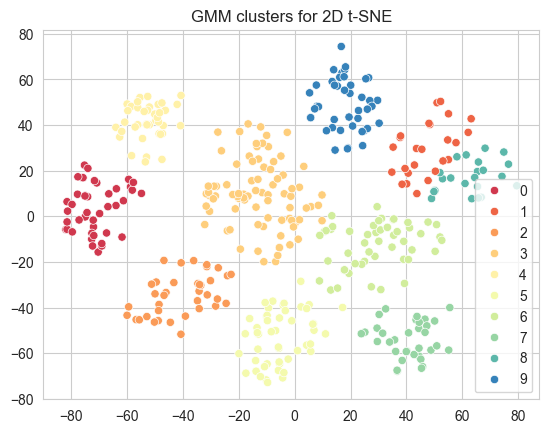

In [59]:
# recrear los mejores resultados ?
# t-SNE 2D + OWN KMEANS++
gmm = GMM.GMM(n_clusters=10, print_freq=200, tol=0.05)
t_pred = gmm.fit_predict(train_tsne_2d, means=kmeans_tsne_2d.centroids)
pred = gmm.predict(val_tsne_2d)
pred = pd.Categorical(pred)
metrics = calculate_clustering_metrics(X=val_tsne_2d, cluster_labels=pred, true_labels=y_val_encoded)
print(calculate_clustering_metrics(X=train_tsne_2d, cluster_labels=t_pred, true_labels=y_train))
print(metrics)

# predicciones para submission
# test_pred = gmm.predict(test_tsne_2d)
# submission = pd.DataFrame({'youtube_id':test_ids.flatten(), 'label': test_pred.flatten()})
# submission.to_csv('2d_tsne_gmm.csv', index=False)

sns.scatterplot(x=val_tsne_2d[:,0], y=val_tsne_2d[:,1], hue=pred, palette='Spectral')
plt.title('GMM clusters for 2D t-SNE')
plt.show()

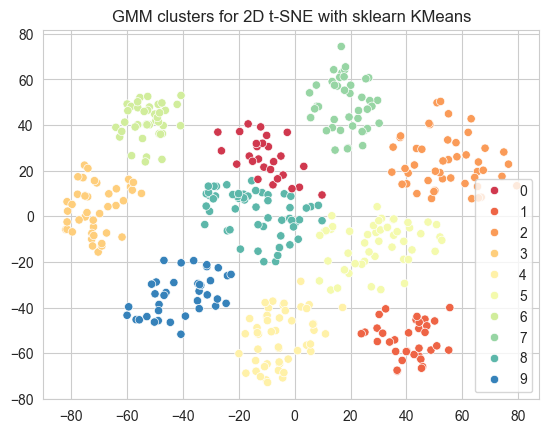

In [57]:
# # recrear los mejores resultados ?
# # t-SNE 2D + SCIKIT KMEANS
gmm = GMM.GMM(n_clusters=10, print_freq=200, tol=0.05)
t_pred = gmm.fit_predict(train_tsne_2d, means=skmeans_tsne_2d.cluster_centers_)
pred = gmm.predict(val_tsne_2d)
pred = pd.Categorical(pred)
metrics = calculate_clustering_metrics(X=val_tsne_2d, cluster_labels=pred, true_labels=y_val_encoded)
print(calculate_clustering_metrics(X=train_tsne_2d, cluster_labels=t_pred, true_labels=y_train))
print(metrics)

# # predicciones para submission
test_pred = gmm.predict(test_tsne_2d)
submission = pd.DataFrame({'youtube_id':test_ids.flatten(), 'label': test_pred.flatten()})
submission.to_csv('2d_tsne_gmm.csv', index=False)

sns.scatterplot(x=val_tsne_2d[:,0], y=val_tsne_2d[:,1], hue=pred, palette='Spectral')
plt.title('GMM clusters for 2D t-SNE with sklearn KMeans')
plt.show()

log likelihood at iteration 0 : -61585.771149970744
Converged at  65 iterations
{'silhouette': np.float32(0.38145643), 'rand_index': np.float64(0.96211012482025), 'rand_index_adjusted': 0.8127931028695025, 'mutual_info': np.float64(2.029442225368673), 'mutual_info_normalized': np.float64(0.9069442215145512)}
{'silhouette': np.float32(0.3528015), 'rand_index': np.float64(0.9443137254901961), 'rand_index_adjusted': 0.7070329282852216, 'mutual_info': np.float64(1.8082664577309582), 'mutual_info_normalized': np.float64(0.7988972866941695)}


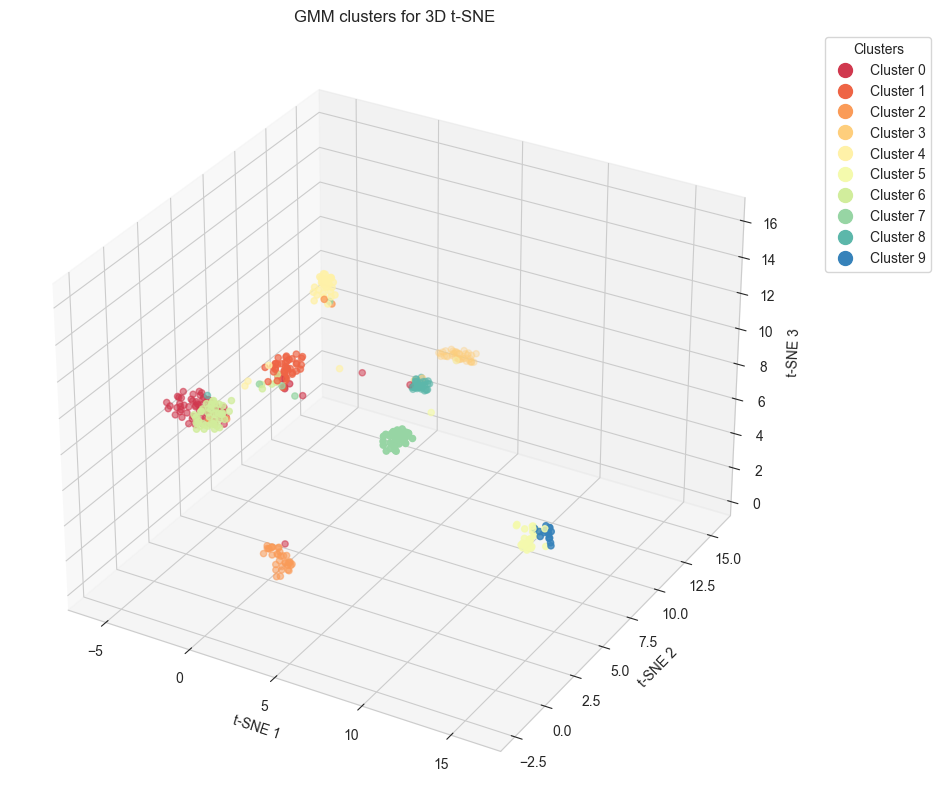

In [49]:
# recrear los mejores resultados ?
# t-SNE 3D
gmm = GMM.GMM(n_clusters=10, print_freq=200, tol=0.05)
t_pred = gmm.fit_predict(train_tsne_3d, means=skmeans_tsne_3d.cluster_centers_)
pred = gmm.predict(val_tsne_3d)
metrics = calculate_clustering_metrics(X=val_tsne_3d, cluster_labels=pred, true_labels=y_val_encoded)
print(calculate_clustering_metrics(X=train_tsne_3d, cluster_labels=t_pred, true_labels=y_train))
print(metrics)

# predicciones para submission
test_pred = gmm.predict(test_tsne_3d)
submission = pd.DataFrame({'youtube_id':test_ids.flatten(), 'label': test_pred.flatten()})
submission.to_csv('3d_tsne_gmm_v3.csv', index=False)

# plot
unique_labels = np.unique(pred)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

palette = sns.color_palette('Spectral', len(unique_labels))
colors = [palette[label] for label in pred]

scatter = ax.scatter(val_umap_3d[:, 0], val_umap_3d[:, 1], val_umap_3d[:, 2], c=colors)

handles = [plt.Line2D([0], [0], marker='o', color=palette[i], linestyle='', markersize=10) for i in range(len(unique_labels))]
labels = [f'Cluster {label}' for label in unique_labels]
ax.legend(handles, labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title('GMM clusters for 3D t-SNE')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

plt.show()

log likelihood at iteration 0 : -17492.670003540465
Converged at  25 iterations
{'silhouette': np.float32(0.7722043), 'rand_index': np.float64(0.9904809878065167), 'rand_index_adjusted': 0.9498020851355734, 'mutual_info': np.float64(2.161174742039453), 'mutual_info_normalized': np.float64(0.9522137917248875)}
{'silhouette': np.float32(0.7157937), 'rand_index': np.float64(0.9628831814415907), 'rand_index_adjusted': 0.7914895800707878, 'mutual_info': np.float64(1.9253337696273354), 'mutual_info_normalized': np.float64(0.8376881626164917)}


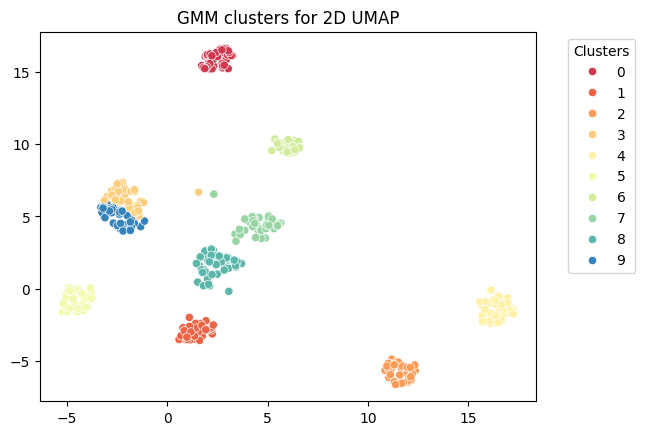

In [30]:
# recrear los mejores resultados ?
# UMAP 2D
gmm = GMM.GMM(n_clusters=10, print_freq=200, tol=1)
t_pred = gmm.fit_predict(train_umap_2d, means=kmeans_umap_2d.centroids)
pred = gmm.predict(val_umap_2d) # para ver todos los colores en la leyenda C:
pred = pd.Categorical(pred)
metrics = calculate_clustering_metrics(X=val_umap_2d, cluster_labels=pred, true_labels=y_val_encoded)
print(calculate_clustering_metrics(X=train_umap_2d, cluster_labels=t_pred, true_labels=y_train))
print(metrics)

# predicciones para submission
test_pred = gmm.predict(test_umap_2d)
submission = pd.DataFrame({'youtube_id':test_ids.flatten(), 'label': test_pred.flatten()})
submission.to_csv('2d_umap_gmm.csv', index=False)

sns.scatterplot(x=val_umap_2d[:,0], y=val_umap_2d[:,1], hue=pred, palette='Spectral')
plt.title('GMM clusters for 2D UMAP')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

log likelihood at iteration 0 : -15424.099973204946
Converged at  169 iterations
{'silhouette': np.float32(0.7712771), 'rand_index': np.float64(0.9881931955052726), 'rand_index_adjusted': 0.9382270768625074, 'mutual_info': np.float64(2.1447593032560714), 'mutual_info_normalized': np.float64(0.9468342104537271)}
{'silhouette': np.float32(0.72115016), 'rand_index': np.float64(0.9581883457608396), 'rand_index_adjusted': 0.7673322809919868, 'mutual_info': np.float64(1.88868716258492), 'mutual_info_normalized': np.float64(0.8235485311812447)}


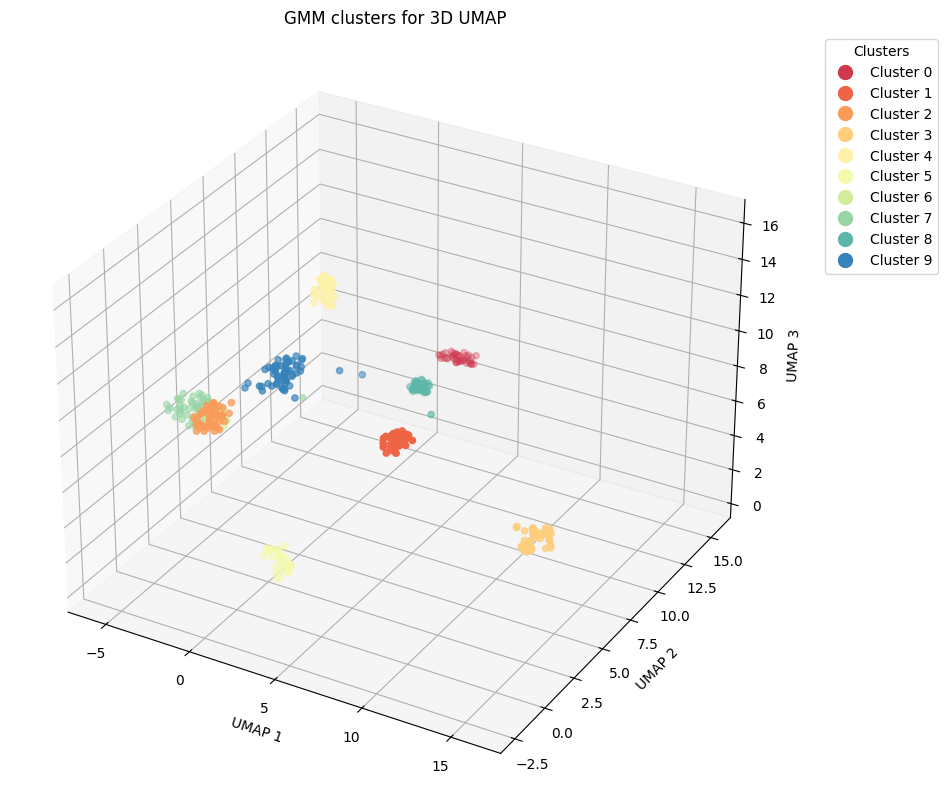

In [19]:
# recrear los mejores resultados ?
# UMAP 3D
gmm = GMM.GMM(n_clusters=10, print_freq=200)
t_pred = gmm.fit_predict(train_umap_3d, means=kmeans_umap_3d.centroids)
pred = gmm.predict(val_umap_3d)
pred = pd.Categorical(pred)
metrics = calculate_clustering_metrics(X=val_umap_3d, cluster_labels=pred, true_labels=y_val_encoded)
print(calculate_clustering_metrics(X=train_umap_3d, cluster_labels=t_pred, true_labels=y_train))
print(metrics)

# predicciones para submission
test_pred = gmm.predict(test_umap_3d)
submission = pd.DataFrame({'youtube_id':test_ids.flatten(), 'label': test_pred.flatten()})
submission.to_csv('3d_umap_gmm.csv', index=False)

# plot
unique_labels = np.unique(pred)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

palette = sns.color_palette('Spectral', len(unique_labels))
colors = [palette[label] for label in pred]

scatter = ax.scatter(val_umap_3d[:, 0], val_umap_3d[:, 1], val_umap_3d[:, 2], c=colors)

handles = [plt.Line2D([0], [0], marker='o', color=palette[i], linestyle='', markersize=10) for i in range(len(unique_labels))]
labels = [f'Cluster {label}' for label in unique_labels]
ax.legend(handles, labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title('GMM clusters for 3D UMAP')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')

plt.show()